# Objective

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint

# Import common modules
from Common_Stockdata import get_stock_data
from Common_Unemploymentdata import get_unemployment_data

# Import the API key
from api_keys import bls_api_key, alpha_vantage_api_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [3]:
unemployment_data_df = get_unemployment_data()
unemployment_data_df.dtypes

Year      object
Month     object
Rate     float64
dtype: object

In [5]:
# Load the Stock DataFrame using the function from your module
stock_info_df = get_stock_data()
stock_info_df.dtypes

Date            datetime64[ns]
Open                   float64
High                    object
Low                     object
Close                  float64
Volume                  object
Year                     int32
Month_Number             int32
dtype: object

# Part 1: Find monthly unemployment data in US

### U.S.Bureau of Labor Statistics (BLS)
Refer to https://www.bls.gov/developers/home.htm for BLS API webpage. Referencing BLS data, extract unemployment data for the past decade from 2013 till 2024 and plot a scatter plot.

### Identify Series ID for unemployment rate
Referencing https://beta.bls.gov/dataQuery/find?q=unemployment to find series ID info for unemployment.

Required series ID is **LNS14000000**.

In [2]:
# Set base url
base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# Set parameters
seriesid = 'LNS14000000'
startyear = 2013
endyear = 2023
registrationkey = bls_api_key

# Create parameter dictionary
params = {'seriesid':[seriesid],
          'startyear':startyear,
          'endyear':endyear,
          'registrationkey':registrationkey}

# Run a request and return response
response = requests.post(base_url, json=params)

# Convert response to json
response_json = response.json()

In [3]:
# set up list to hold reponse info
unemployment_data = []

# Loop through the list of unemployment data and store data on each year in a list
unemployment_years = response_json['Results']['series'][0]['data']

for list in unemployment_years:
    
    unemployment_data.append({'Year': list['year'],
                              'Month': list['periodName'],
                              'Rate': list['value']})

# Create data frame based on collected list
unemployment_df = pd.DataFrame(unemployment_data)

# Convert columns type
unemployment_df['Rate'] = unemployment_df['Rate'].astype(float)
unemployment_df['Year'] = unemployment_df['Year'].astype(int)
unemployment_df['Month'] = unemployment_df['Month'].astype(object)

# Part 2: Find Monthly Stock Profit of ticker
Monthly profits [same month with unemployement announce] (y-axis) vs unemployeement rate (x-axis) by scatter plot.

**Note: Monthly profits is defined by the stock price at 'close' of the month minus stock price at 'Open' of the month.**

### Alpha Vantage
Reference https://www.alphavantage.co/documentation/#monthly.

### Ticker symbol QQQ
Reference https://www.nasdaq.com/market-activity/etf/qqq. This is based on NASDAQ-100 index.

In [4]:
# Set base url
base_url = 'https://www.alphavantage.co/query?'

# Set parameters
function = 'TIME_SERIES_MONTHLY'
symbol = 'QQQ'
apikey = alpha_vantage_api_key

# Create parameter dictionary
params = {'function': function,
          'symbol': symbol,
          'apikey': apikey}

# Run a request and return response
response = requests.get(base_url, params=params)

# Convert response to json
response_json = response.json()

In [5]:
# Create an empty list to store stock price
ticker_prices = []

# Loop through the list of price data and store in a list
ticker_price = response_json['Monthly Time Series']

# Iterate key-value pairs of the list
for date, value in ticker_price.items():
    
    ticker_prices.append({'Date': date,
                          'Open': value['1. open'],
                          'Close': value['4. close']})

# Create data frame based on collected list
ticker_df = pd.DataFrame(ticker_prices)

# Convert Date columnb type from object to datetime
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], format='%Y-%m-%d')

# Convert profit column from object to float and into unit (millions)
ticker_df['Open'] = ticker_df['Open'].astype(float)
ticker_df['Close'] = ticker_df['Close'].astype(float)

# Create new columns for data frame
# Extract year and month
ticker_df['Year'] = ticker_df['Date'].dt.year
ticker_df['Month'] = ticker_df['Date'].dt.month
ticker_df['Monthly Profits'] = ticker_df['Close'] - ticker_df['Open']

# Convert month from integer to string
ticker_df['Month'] = pd.to_datetime(ticker_df['Month'].astype(str), format='%m').dt.month_name()

# Remove irrelevant columns
ticker_df = ticker_df.loc[:, ['Year', 'Month', 'Monthly Profits']]

The r-squared is: 0.0478


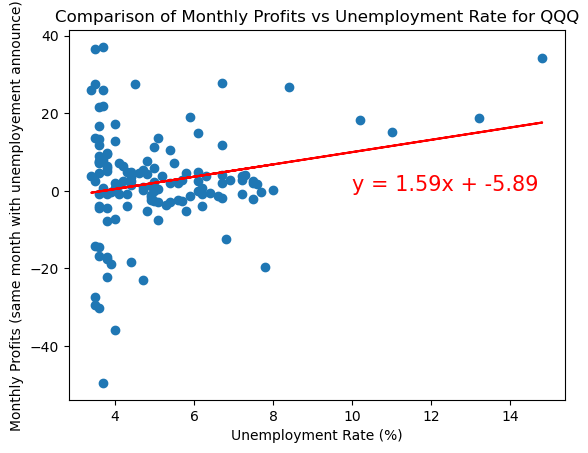

In [6]:
# Combine both data frames
combined_df = pd.merge(ticker_df, unemployment_df, how='inner', on=['Year','Month'])

# Add the linear regression equation and line to plot
x_values = combined_df['Rate']
y_values = combined_df['Monthly Profits']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Adjust the annotated location as required
plt.annotate(line_eq,(10,-0),fontsize=15,color="red")
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Monthly Profits (same month with unemployement announce)')
plt.title(f'Comparison of Monthly Profits vs Unemployment Rate for {symbol}')

# Print the r squared value
print(f"The r-squared is: {round(rvalue**2, 4)}")

# Show plot
plt.show()

# Part 3: Find Monthly Stock Profit of ticker
Monthly profits [one month before unemployement announce] (y-axis) vs unemployeement rate (x-axis) by scatter plot

In [7]:
# Modify unemployment data frame to suit Monthly profits [one month before unemployement announce] by creating a new column with the months moved down by one row.
# Make a copy of the data frame
unemployment_month_before_df = unemployment_df

# Offset the data in 'Column1' by 1 place downwards
unemployment_month_before_df['Month Before'] = unemployment_month_before_df['Month'].shift(-1)

# Rename ticker data frame month column to month before
ticker_month_before_df = ticker_df.rename(columns={'Month':'Month Before'})

The r-squared is: 0.0086


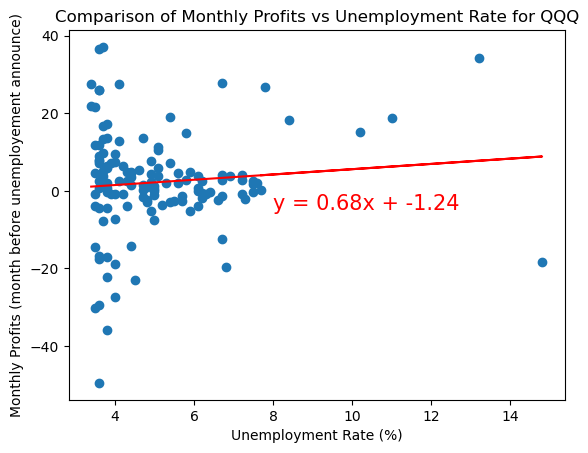

In [11]:
# Combine both data frames
combined_df = pd.merge(ticker_month_before_df, unemployment_month_before_df, how='inner', on=['Year','Month Before'])

# Add the linear regression equation and line to plot
x_values = combined_df['Rate']
y_values = combined_df['Monthly Profits']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Adjust the annotated location as required
plt.annotate(line_eq,(8,-5),fontsize=15,color="red")
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Monthly Profits (month before unemployement announce)')
plt.title(f'Comparison of Monthly Profits vs Unemployment Rate for {symbol}')

# Print the r squared value
print(f"The r-squared is: {round(rvalue**2, 4)}")

# Show plot
plt.show()

# Part 4: Find Monthly Stock Profit of ticker
Monthly profits [one month after unemployement announce] (y-axis) vs unemployeement rate (x-axis) by scatter plot

In [12]:
# Modify unemployment data frame to suit Monthly profits [one month before unemployement announce] by creating a new column with the months moved down by one row.
# Make a copy of the data frame
unemployment_month_after_df = unemployment_df

# Offset the data in 'Column1' by 1 place downwards
unemployment_month_after_df['Month After'] = unemployment_month_before_df['Month'].shift(1)

# Rename ticker data frame month column to month after
ticker_month_after_df = ticker_df.rename(columns={'Month':'Month After'})

The r-squared is: 0.0307


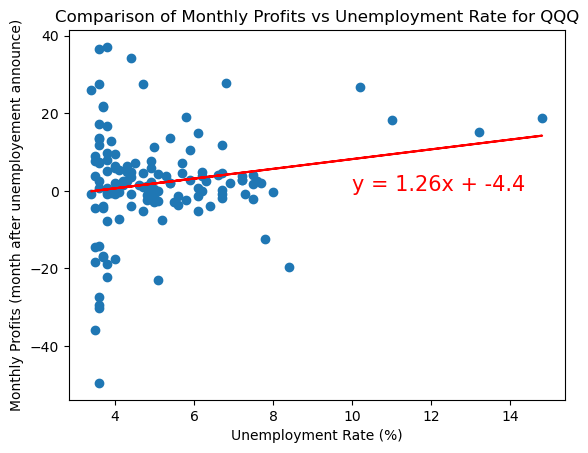

In [14]:
# Combine both data frames
combined_df = pd.merge(ticker_month_after_df, unemployment_month_after_df, how='inner', on=['Year','Month After'])

# Add the linear regression equation and line to plot
x_values = combined_df['Rate']
y_values = combined_df['Monthly Profits']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Adjust the annotated location as required
plt.annotate(line_eq,(10,-0),fontsize=15,color="red")
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Monthly Profits (month after unemployement announce)')
plt.title(f'Comparison of Monthly Profits vs Unemployment Rate for {symbol}')

# Print the r squared value
print(f"The r-squared is: {round(rvalue**2, 4)}")

# Show plot
plt.show()